Training a neural network to predict $\delta C_9$ on a set basis (classification)

Import Libraries

In [1]:
import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax, softmax

from library.nn_training import train_and_eval, select_device
from library.plotting import setup_high_quality_mpl_params, plot_loss_curves, plot_likelihood_over_bins, plot_prediction_linearity
from library.datasets import Bootstrapped_Signal_Binned_Dataset
from library.util import bootstrap_over_bins

In [2]:
setup_high_quality_mpl_params()

Define Helper Functions

Define Model

In [ ]:
model_save_path = "../../state/new_physics/models/set_nn.pt"

class Set_NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.f = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 44)
         )

        self.f = nn.Sequential(
            nn.Linear(4, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 44)
         )
        
        self.g = nn.Sequential(
            nn.Linear(256, )
        )
        
        self.double()

    def forward(self, x):
        result = torch.mean(self.layers(x), dim=1)
        return result
    


Select Device

In [5]:
device = select_device()

Device:  cuda


Load / Generate Datasets

In [6]:
level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"
num_events_per_set = 24_000

train_dataset = Bootstrapped_Signal_Binned_Dataset(level=level, split="train", save_dir=save_dir)
train_raw_trials = range(0,30)
train_num_sets_per_label = 12
# train_dataset.generate(train_raw_trials, raw_signal_dir, num_events_per_set, train_num_sets_per_label)
train_dataset.load()

eval_dataset = Bootstrapped_Signal_Binned_Dataset(level=level, split="eval", save_dir=save_dir)
eval_raw_trials = range(30,40)
eval_num_sets_per_label = 10
# eval_dataset.generate(eval_raw_trials, raw_signal_dir, num_events_per_set, eval_num_sets_per_label)
eval_dataset.load()


Train / Load Model


epoch 0 complete:
    Train loss: 3.7951500572882186
    Eval loss: 3.7847237787349037

peak gpu memory usage: 7.36685 GB

epoch 1 complete:
    Train loss: 3.7880980565103757
    Eval loss: 3.785731845386962

peak gpu memory usage: 7.36685 GB

epoch 2 complete:
    Train loss: 3.7871782544656893
    Eval loss: 3.7844487210159516

peak gpu memory usage: 7.36685 GB

epoch 3 complete:
    Train loss: 3.7861939011037267
    Eval loss: 3.7846105821246203

peak gpu memory usage: 7.36685 GB

epoch 4 complete:
    Train loss: 3.7861442070716054
    Eval loss: 3.784304960830619

peak gpu memory usage: 7.36685 GB

epoch 5 complete:
    Train loss: 3.785891933029717
    Eval loss: 3.784243776731666

peak gpu memory usage: 7.36685 GB

epoch 6 complete:
    Train loss: 3.786195209366908
    Eval loss: 3.7841691951859016

peak gpu memory usage: 7.36685 GB

epoch 7 complete:
    Train loss: 3.785553871183665
    Eval loss: 3.784400820555416

peak gpu memory usage: 7.36685 GB

epoch 8 complete:
    

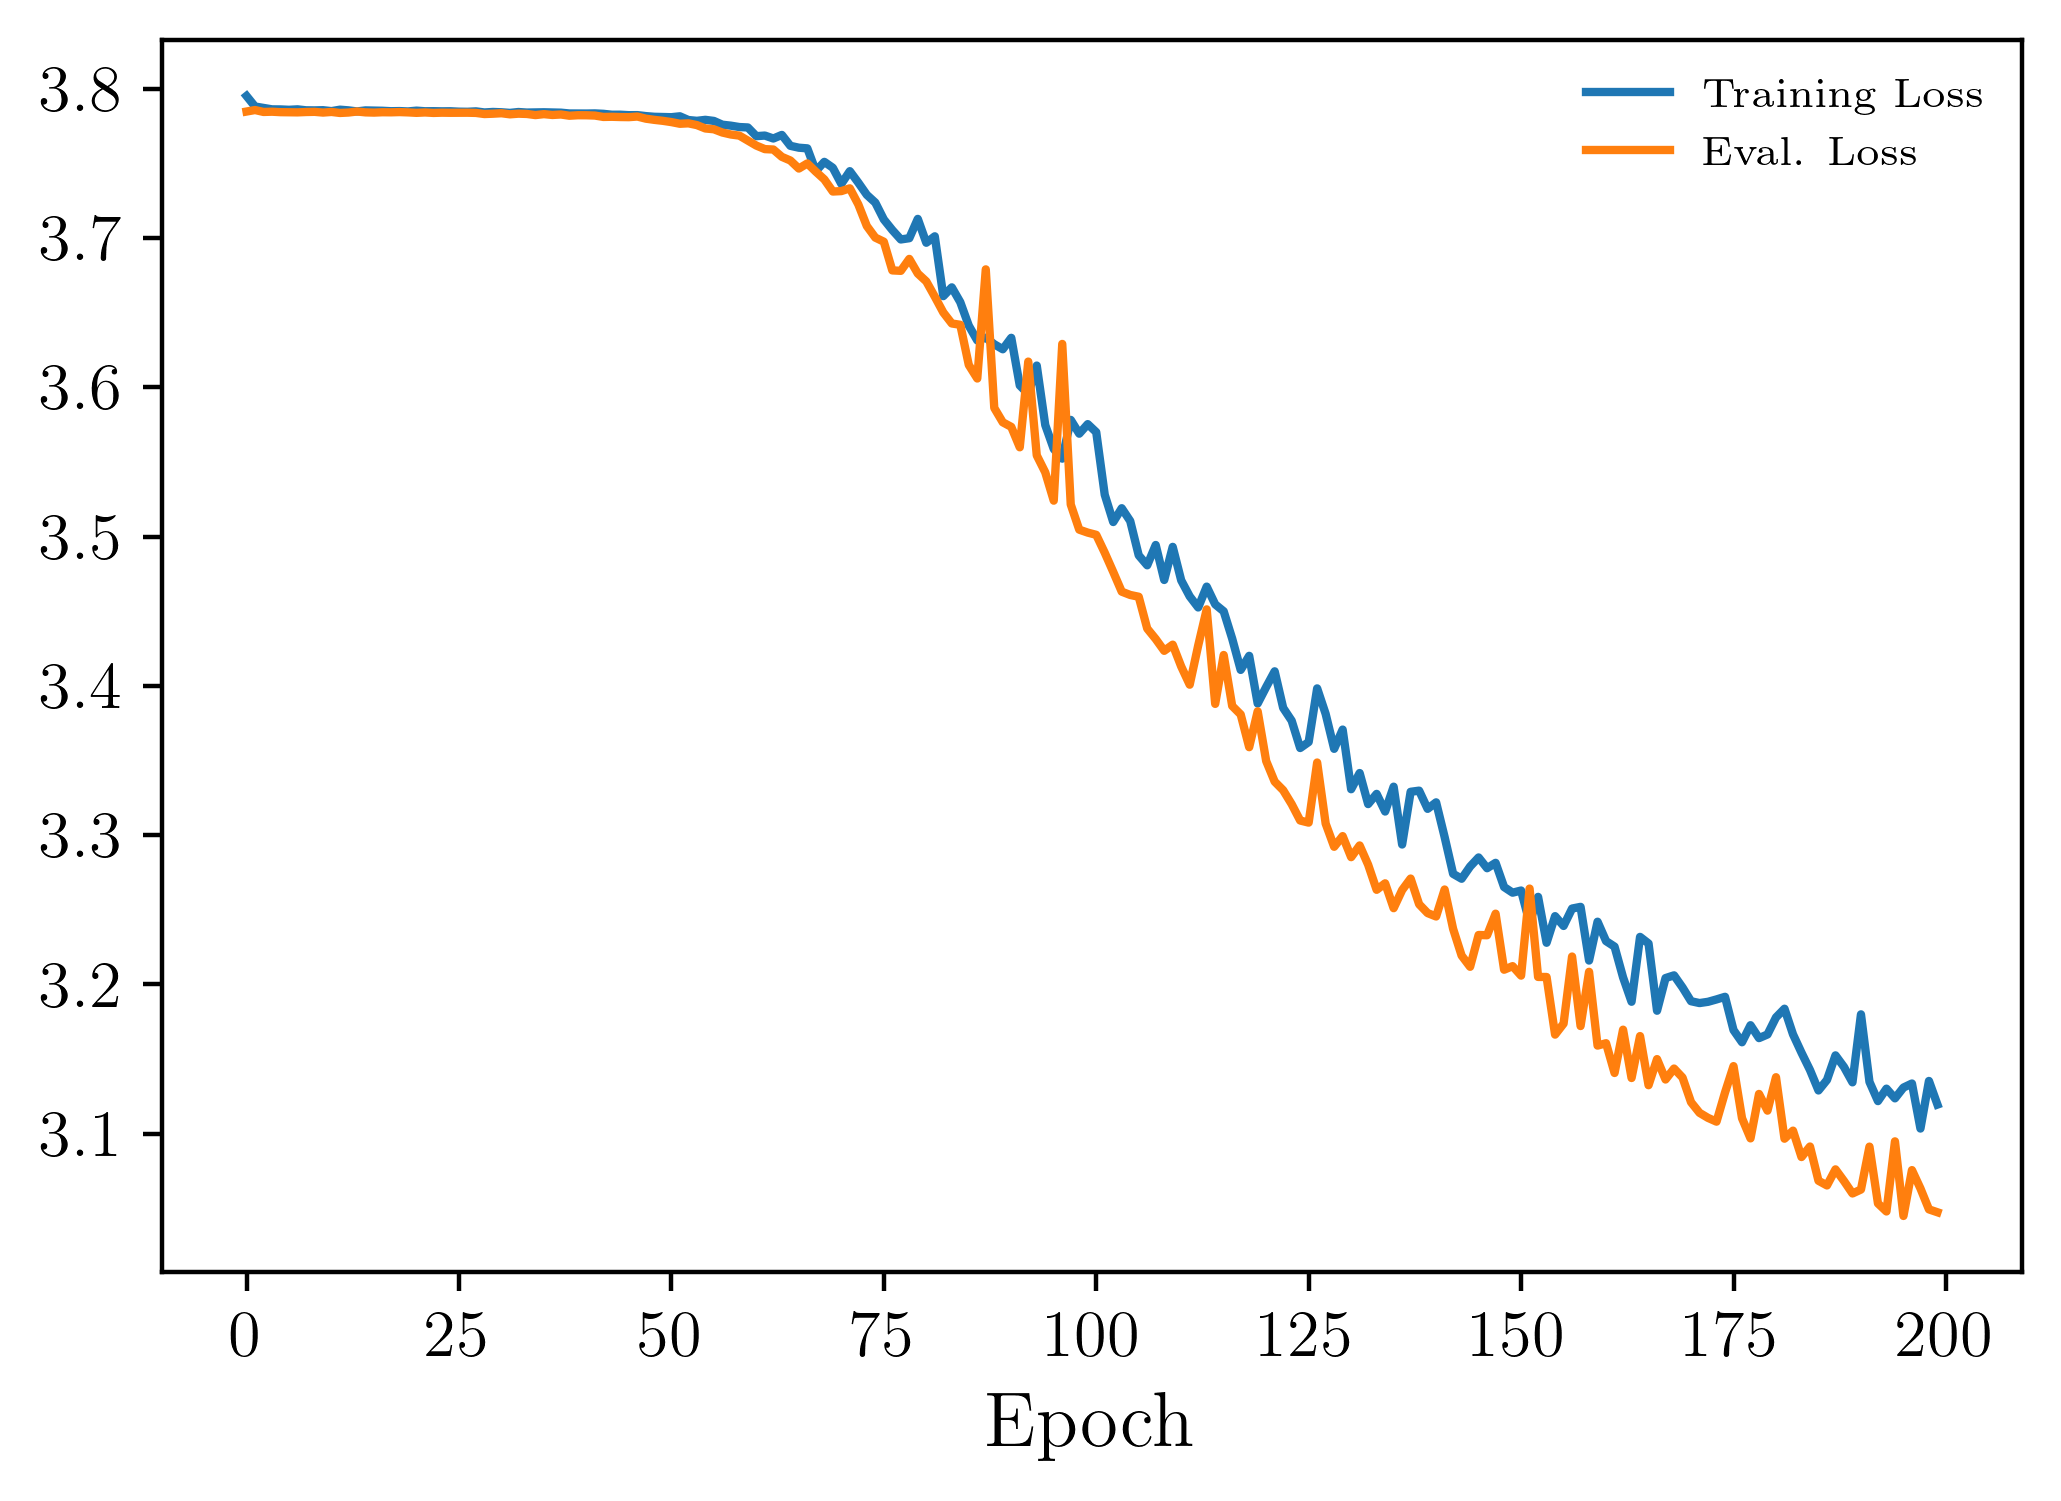

In [7]:
retrain = True
model = Set_NN()

if retrain:
    
    learning_rate = 4e-4
    epochs = 200
    train_batch_size = 32
    eval_batch_size = 32
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        train_dataset, eval_dataset, 
        loss_fn, 
        optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=True)
    torch.save(model.state_dict(), model_save_path)
    _, ax = plt.subplots()
    plot_loss_curves(loss_table["epoch"], loss_table["train_loss"], loss_table["eval_loss"], ax)
    plt.show()
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))
    model.to(device)

Evaluate Model

we tensor(30.5232, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1.0000, dtype=torch.float64)
we tensor(27.6530, dtype=torch.float64)
argmax tensor(24)
sum p tensor(1., dtype=torch.float64)
we tensor(28.8362, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1.0000, dtype=torch.float64)
we tensor(28.1868, dtype=torch.float64)
argmax tensor(29)
sum p tensor(1., dtype=torch.float64)
we tensor(29.0990, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1., dtype=torch.float64)
we tensor(28.7678, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1.0000, dtype=torch.float64)
we tensor(28.6606, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1.0000, dtype=torch.float64)
we tensor(29.0484, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1., dtype=torch.float64)
we tensor(29.8099, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1., dtype=torch.float64)
we tensor(29.8981, dtype=torch.float64)
argmax tensor(42)
sum p tensor(1., dtype=torch.float64)


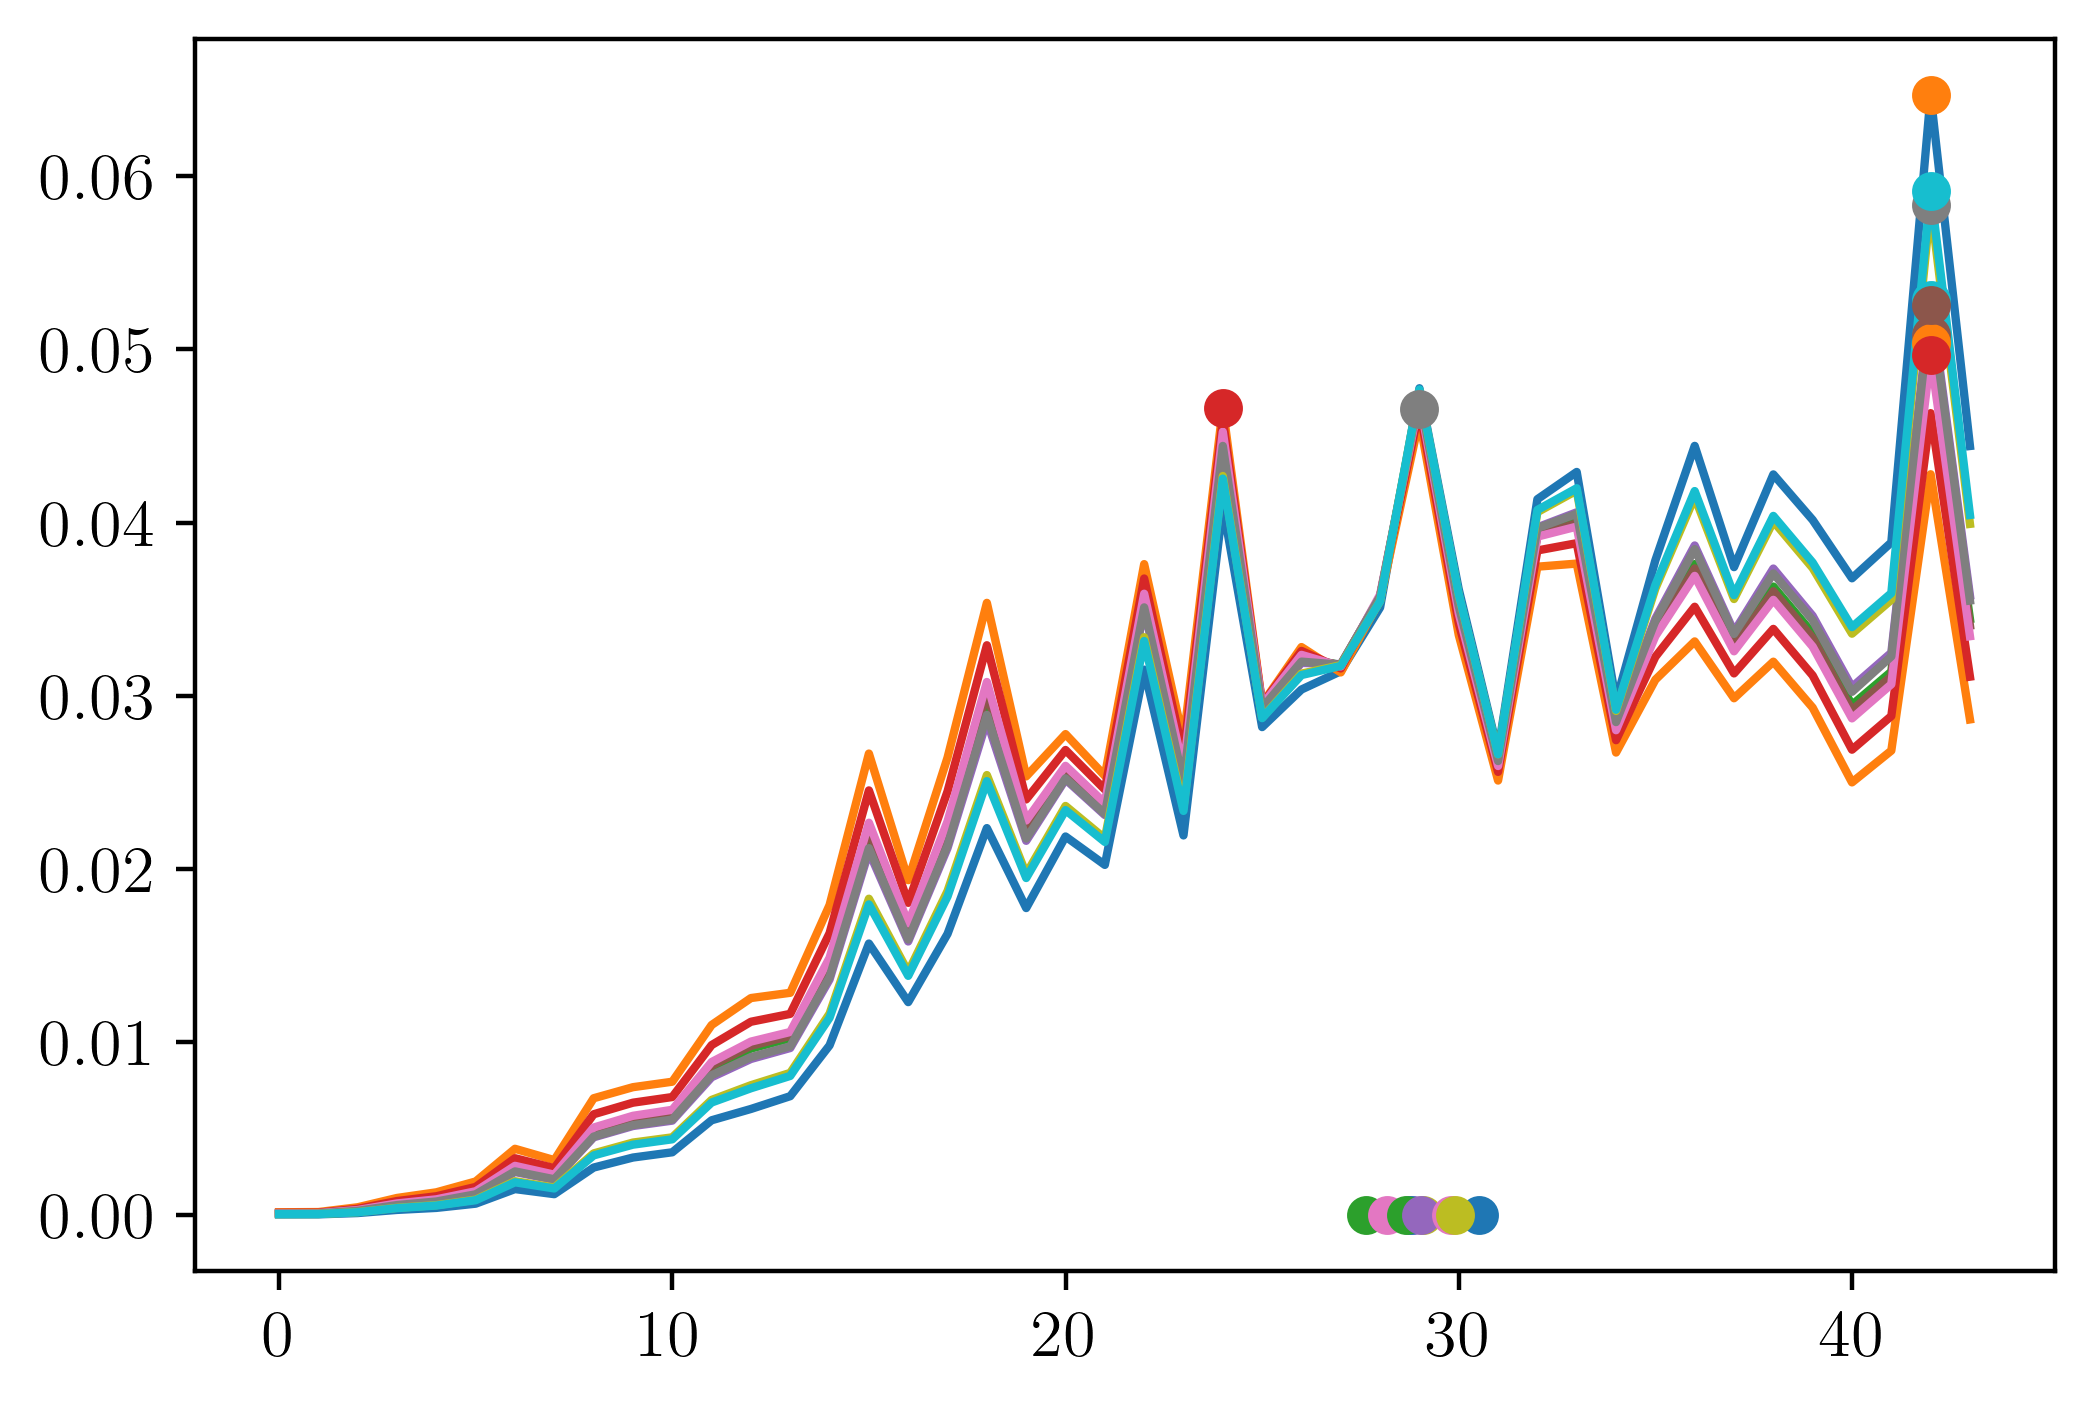

In [29]:
label = 32
log_p = softmax(model(eval_dataset.features[eval_dataset.labels==label].to(device)), dim=1)
for sset in log_p.detach().cpu():
    plt.plot(sset)
    n_bins = len(sset)
    bins = torch.arange(n_bins)
    weighted_avg = torch.sum(bins * sset) / torch.sum(sset)
    print("we", weighted_avg)
    print("argmax", torch.argmax(sset))
    print("sum p", torch.sum(sset))
    plt.scatter(weighted_avg.item(), 0)
    plt.scatter(torch.argmax(sset), torch.max(sset), zorder=10)

In [ ]:
value_guesses = []
for label in range(0, 44):
    log_p = log_softmax(model(eval_dataset.features[eval_dataset.labels==label].to(device)), dim=1)
    bin_guess = torch.argmax(log_p, dim=1).to("cpu")
    value_guess = eval_dataset.bin_values[bin_guess]
    value_guesses.append(value_guess)

value_guesses = [np.expand_dims(guess, axis=0) for guess in value_guesses]
value_guesses = np.concat(value_guesses)
value_guess_stds = np.std(value_guesses, axis=1)
value_guess_means = np.mean(value_guesses, axis=1)
    

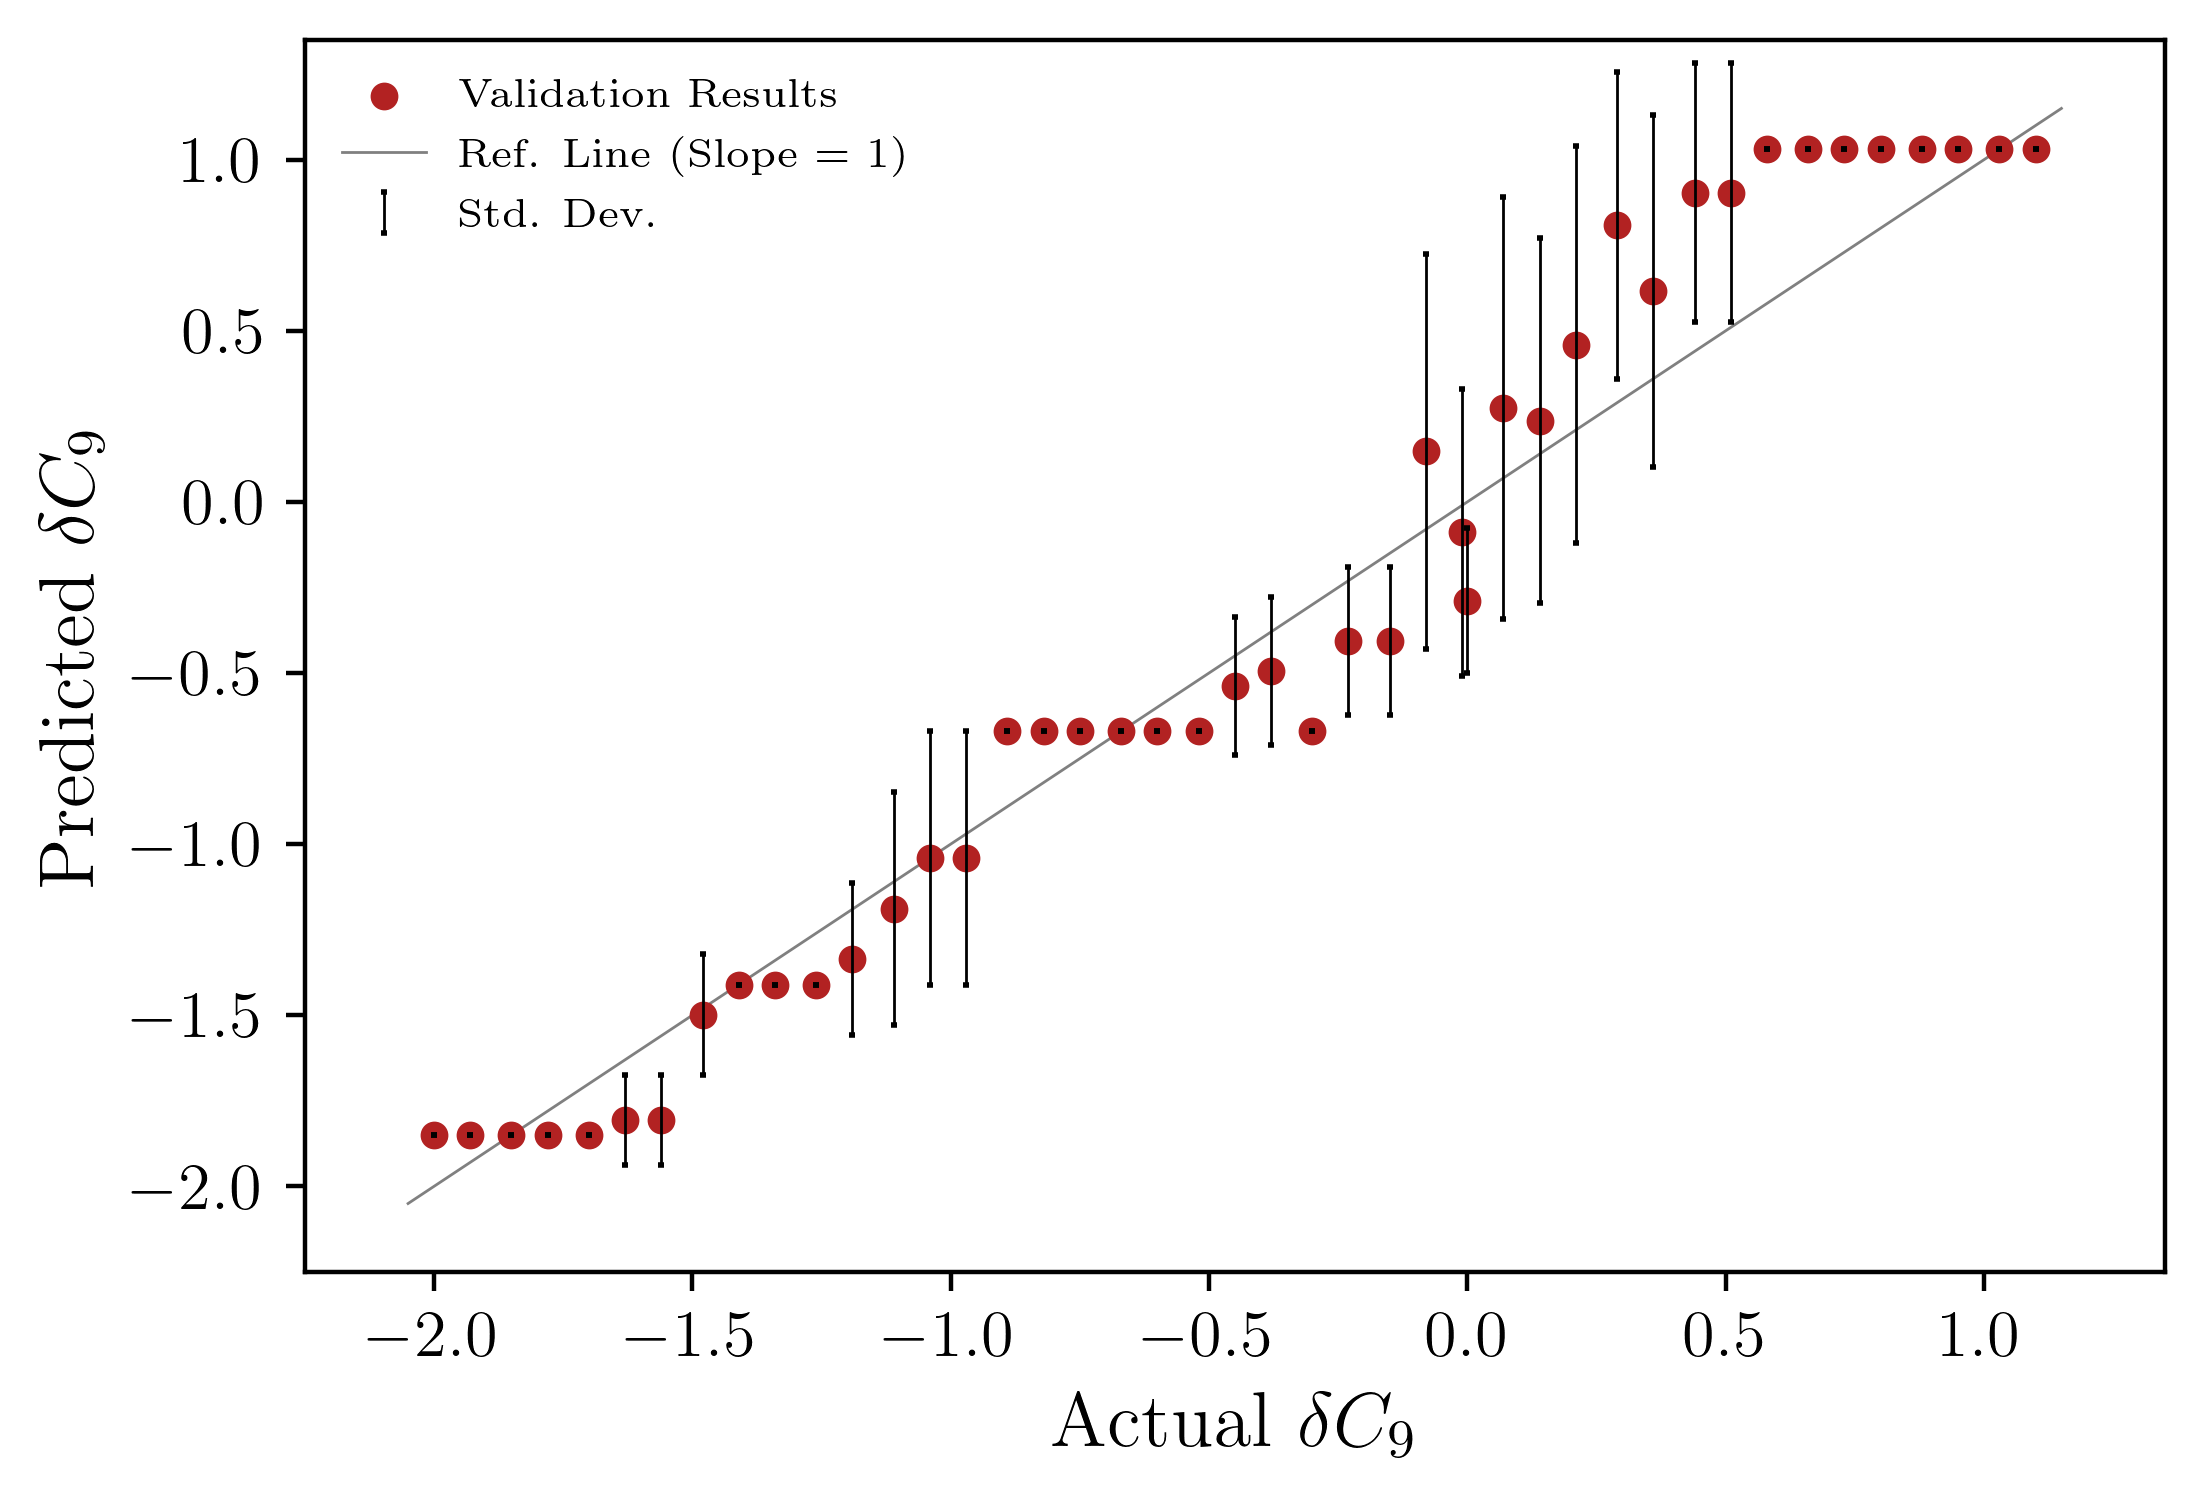

In [12]:
plot_prediction_linearity(
    eval_dataset.bin_values,
    value_guess_means,
    value_guess_stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
